# PSD Analysis Theta R

## Load necessary libraries
If any of these don't load, you'll need to install them. Assuming you installed Jupyter through Anaconda, you would do the following to install a package
`conda install -c r r-[pkgName]`
e.g., to install ggplot2 you would do:
`conda install -c r r-ggplot2`

In [1]:
R.home()

[1] "/opt/conda/lib/R"

In [2]:
library(ggplot2)
library(mgcv)
library(parallel)
library(plyr)
library(tidyr)
library(data.table)
library(viridis)
# library(ggthemes)
library(nlme)

Loading required package: nlme
This is mgcv 1.8-29. For overview type 'help("mgcv-package")'.
Loading required package: viridisLite


## Load Data

In [3]:
topdir = getwd()
source(paste(topdir,'/NCIL_functions.R',sep=""))
num_cores = 4

dat = read.csv("osc_data/theta.csv")

head(dat)

X,Subj,PSD,Stim,Channel,Condition,Region,Band,Electrode_by_Subj,Stim_by_Subj,Cond_by_Subj
<int>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
0,1,-117.5613,standard,POz,MW1,occipital,theta,POz_1,standard_1,MW1_1
1,1,-115.7581,standard,POz,MW1,occipital,theta,POz_1,standard_1,MW1_1
2,1,-113.6752,standard,POz,MW1,occipital,theta,POz_1,standard_1,MW1_1
3,1,-115.4125,standard,POz,MW1,occipital,theta,POz_1,standard_1,MW1_1
4,1,-114.5393,standard,POz,MW1,occipital,theta,POz_1,standard_1,MW1_1
5,1,-114.9950,standard,POz,MW1,occipital,theta,POz_1,standard_1,MW1_1


In [4]:
summary(dat)

       X              Subj            PSD                Stim      
 Min.   :    0   Min.   : 1.00   Min.   :-138.83   oddball :10439  
 1st Qu.:17956   1st Qu.:12.00   1st Qu.:-120.43   standard:61386  
 Median :35912   Median :24.00   Median :-117.48                   
 Mean   :35912   Mean   :23.99   Mean   :-117.48                   
 3rd Qu.:53868   3rd Qu.:36.00   3rd Qu.:-114.55                   
 Max.   :71824   Max.   :47.00   Max.   : -95.54                   
                                                                   
    Channel      Condition         Region         Band       Electrode_by_Subj
 CPz    : 5525   MW1:22334   frontal  :27625   theta:71825   CPz_43 :  154    
 F3     : 5525   MW2:24960   occipital:22100                 F3_43  :  154    
 F4     : 5525   MW3: 3419   parietal :22100                 F4_43  :  154    
 Fp1    : 5525   MW4:15613                                   Fp1_43 :  154    
 Fp2    : 5525   MW5: 5499                                   

## Run initial full model to identify and remove outliers

Now run the model

In [5]:
m0 <- bam(PSD ~ Stim * Condition
          + s(Subj, bs="re"),
          data = dat, 
          samfrac=0.1)

In [6]:
dat <- romr.fnc(m0, dat, trim=2.5)$data

m1 <- bam(PSD ~ Stim * Condition 
          + s(Subj, bs="re"),
          data = dat, 
          samfrac=0.1)

n.removed = 1089 
percent.removed = 1.516185 


#### Find and remove outliers, then update model


Method: fREML   Optimizer: perf newton
full convergence after 11 iterations.
Gradient range [-1.140104e-05,1.133369e-05]
(score 208557.6 & scale 19.47449).
Hessian positive definite, eigenvalue range [0.4980513,35908.5].
Model rank =  9 / 11 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

           k'   edf k-index p-value    
s(Subj) 1.000 0.998    0.77  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


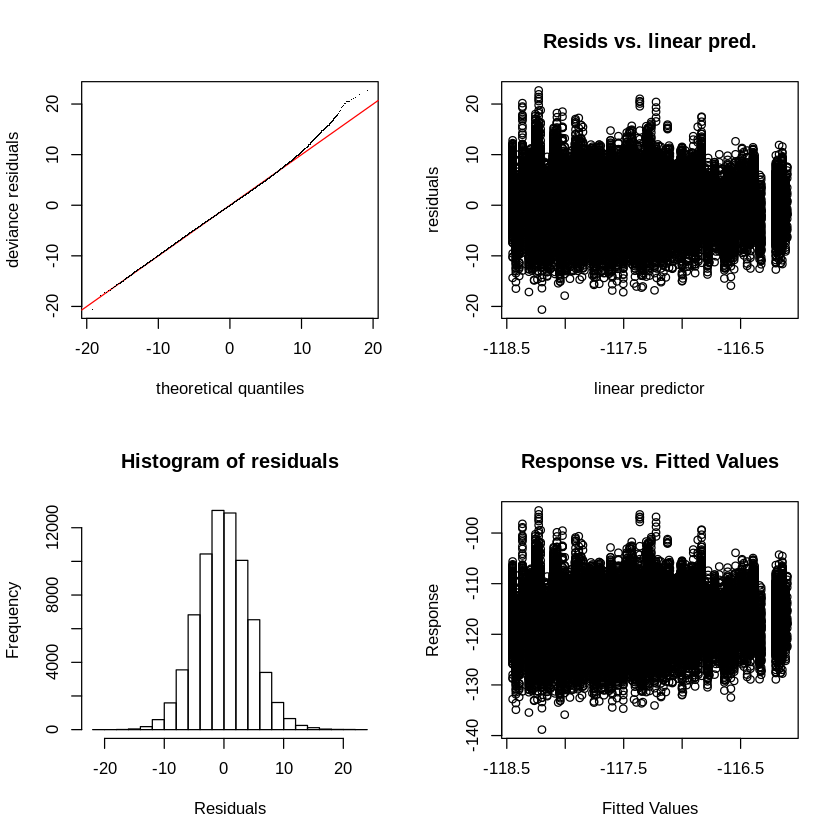

In [7]:
gam.check(m0)


Method: fREML   Optimizer: perf newton
full convergence after 11 iterations.
Gradient range [-0.0001869368,0.0001861783]
(score 200915.8 & scale 17.15726).
Hessian positive definite, eigenvalue range [0.4988605,35364].
Model rank =  9 / 11 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

           k'   edf k-index p-value    
s(Subj) 1.000 0.999    0.78  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


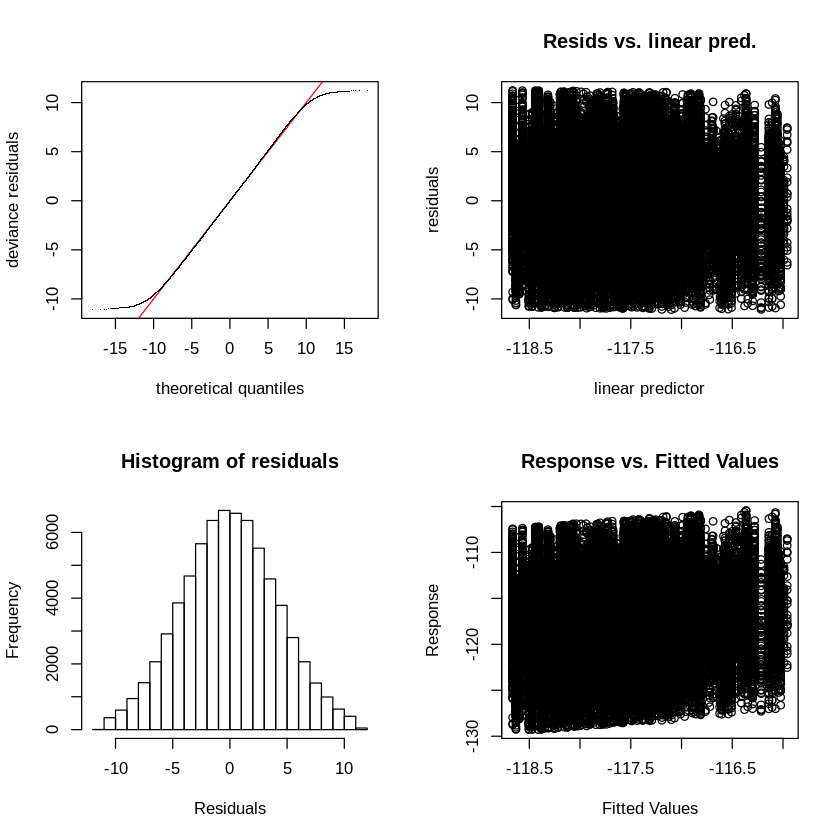

In [8]:
gam.check(m1)

## Compute LME usind data from the frontal region

In [9]:
bdat <- dat

In [10]:
dat <- bdat

In [11]:
dat <- subset(bdat, Region == 'frontal') #change this as needed

# relevel data to focus on standard and MW1

dat[,'Condition'] <- relevel(dat[,'Condition'],'MW1')
dat[,'Stim'] <- relevel(dat[,'Stim'],'standard')

summary(dat)

       X              Subj           PSD               Stim      
 Min.   :  448   Min.   : 1.0   Min.   :-129.3   standard:23209  
 1st Qu.:18326   1st Qu.:12.0   1st Qu.:-119.7   oddball : 3958  
 Median :36146   Median :24.0   Median :-116.8                   
 Mean   :36241   Mean   :24.1   Mean   :-116.8                   
 3rd Qu.:54140   3rd Qu.:36.0   3rd Qu.:-113.8                   
 Max.   :71824   Max.   :47.0   Max.   :-105.4                   
                                                                 
    Channel     Condition        Region         Band       Electrode_by_Subj
 F3     :5461   MW1:8406   frontal  :27167   theta:27167   F3_43  :  152    
 Fp2    :5446   MW2:9443   occipital:    0                 Fp1_43 :  152    
 F4     :5428   MW3:1300   parietal :    0                 F3_12  :  149    
 Fp1    :5423   MW4:5909                                   F4_12  :  149    
 Fz     :5409   MW5:2109                                   F4_43  :  149    
 CPz    : 

### Try many models

In [12]:
num_cores = 4

cl <- makeCluster(num_cores)

m1r <- bam(PSD ~ Stim * Condition   
          + s(Subj, bs="re") 
           + s(Electrode_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m2r <- bam(PSD ~ Stim * Condition   
          + s(Subj, bs="re") 
           + s(Stim_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m3r <- bam(PSD ~ Stim * Condition   
          + s(Subj, bs="re") 
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m4r <- bam(PSD ~ Stim * Condition  
           + s(Subj, bs="re") 
           + s(Electrode_by_Subj, bs="re")  
           + s(Stim_by_Subj, bs="re"), 
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m5r <- bam(PSD ~ Stim * Condition  
           + s(Subj, bs="re") 
           + s(Electrode_by_Subj, bs="re")  
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m6r <- bam(PSD ~ Stim * Condition  
           + s(Subj, bs="re") 
           + s(Stim_by_Subj, bs="re") 
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m7r <- bam(PSD ~ Stim  # adding this to control for condition
           + s(Condition, bs="re")
           + s(Subj, bs="re") 
           + s(Stim_by_Subj, bs="re") 
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

stopCluster(cl)

### Select best model based on AIC

In [13]:
AICtab = as.data.frame(AIC(m0,m1r,m2r,m3r,m4r,m5r,m6r, m7r))
minAIC =  min(AIC(m0,m1r,m2r,m3r,m4r,m5r,m6r, m7r)[2]) 

AICtab$deltaAIC = lapply(AICtab$AIC, deltaAICfunc)
AICtab$deltaAIC = as.numeric(AICtab$deltaAIC)

AICtab$L= lapply(AICtab$deltaAIC, f)
AICtab$L = as.numeric(AICtab$L)

sumlike = sum(AICtab$L)

AICtab$wAIC = lapply(AICtab$L, wAICfunc)
AICtab$wAIC = as.numeric(AICtab$wAIC)

# compute relative likelihood of each model relative to model with smallest AIC/max wAIC
# So, xBetter is interpreted as "the best model is x times more likely than this model"
wAICmax = max(AICtab$wAIC)
AICtab$xBetter = lapply(AICtab$wAIC, xBetterfunc)
AICtab$xBetter = as.numeric(AICtab$xBetter)

AICtab = AICtab[order(AICtab$deltaAIC),] 
AICtab[,c('df','AIC','deltaAIC','xBetter')]

,df,AIC,deltaAIC,xBetter
,<dbl>,<dbl>,<dbl>,<dbl>
m5r,342.317146,138528.9,0.0000,1.000000e+00
m4r,280.208276,138861.4,332.4777,1.572613e+72
m1r,240.545043,139040.5,511.6122,1.245003e+111
m7r,191.280844,142256.4,3727.5104,Inf
m6r,193.291391,142258.5,3729.5295,Inf
m3r,173.257795,142408.3,3879.4043,Inf
m2r,99.943301,142667.3,4138.4006,Inf
m0,9.999996,417097.5,278568.5882,Inf


### Get summary of the best model
Main effects and interactions. 

In [14]:
mod = m5r

mod_summary = anova(mod)

mod_summary


Family: gaussian 
Link function: identity 

Formula:
PSD ~ Stim * Condition + s(Subj, bs = "re") + s(Electrode_by_Subj, 
    bs = "re") + s(Cond_by_Subj, bs = "re")

Parametric Terms:
               df     F  p-value
Stim            1 0.000 0.985919
Condition       3 5.563 0.000821
Stim:Condition  3 3.756 0.010366

Approximate significance of smooth terms:
                          edf   Ref.df        F  p-value
s(Subj)                0.9021   1.0000    0.902   0.0014
s(Electrode_by_Subj) 224.7233 234.0000 1169.753  < 2e-16
s(Cond_by_Subj)      107.1359 168.0000  183.993 4.02e-14

In [15]:
summary(mod)


Family: gaussian 
Link function: identity 

Formula:
PSD ~ Stim * Condition + s(Subj, bs = "re") + s(Electrode_by_Subj, 
    bs = "re") + s(Cond_by_Subj, bs = "re")

Parametric coefficients:
                           Estimate Std. Error  t value Pr(>|t|)    
(Intercept)              -1.180e+02  3.849e-01 -306.471  < 2e-16 ***
Stimoddball              -1.636e-03  9.268e-02   -0.018  0.98592    
ConditionMW2              6.462e-02  1.955e-01    0.330  0.74105    
ConditionMW3              0.000e+00  0.000e+00       NA       NA    
ConditionMW4              5.676e-01  2.171e-01    2.614  0.00895 ** 
ConditionMW5              9.626e-01  2.961e-01    3.251  0.00115 ** 
Stimoddball:ConditionMW2  0.000e+00  0.000e+00       NA       NA    
Stimoddball:ConditionMW3  4.017e-01  2.366e-01    1.698  0.08959 .  
Stimoddball:ConditionMW4 -1.528e-01  1.436e-01   -1.064  0.28752    
Stimoddball:ConditionMW5  4.542e-01  2.025e-01    2.243  0.02490 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0

## Visualize these results

In [18]:
res <- t(summary(mod)$p.table[3,])
res <- as.data.frame(res)
res$Condition = paste("2 (Somewhat OT)")
posthocs <- res

res <- t(summary(mod)$p.table[4,])
res <- as.data.frame(res)
res$Condition = paste("3 (Niether MW nor OT)")
posthocs <- rbind(posthocs, res)

res <- t(summary(mod)$p.table[5,])
res <- as.data.frame(res)
res$Condition = paste("4 (Somewhat MW)")
posthocs <- rbind(posthocs, res)

res <- t(summary(mod)$p.table[6,])
res <- as.data.frame(res)
res$Condition = paste("5 (Completely MW)")
posthocs <- rbind(posthocs, res)

colnames(posthocs)[2] <- 'SE'
colnames(posthocs)[4] <- 'p (raw)'

# CIs
ncomp  <- dim(posthocs)[1] #-2 # The -2 is bc the age x polynomial contrasts are repeated for each group, but are teh same
thr <- adjust.se(alpha=0.05, df=1000, ncomp=ncomp)
posthocs$CIup <- round(posthocs$Estimate + thr * posthocs$SE, 2)
posthocs$CIdown <- round(posthocs$Estimate - thr * posthocs$SE, 2)

# Round for pretty table
posthocs[,'Estimate'] = round(posthocs[,'Estimate'],2)
posthocs[,'SE'] = round(posthocs[,'SE'],3)
posthocs[,'t value'] = round(posthocs[,'t value'],2)
posthocs[,'p (raw)'] = round(posthocs[,'p (raw)'],5)

# Reorder columns
posthocs = posthocs[,c('Condition', 'Estimate','SE','CIup','CIdown','t value','p (raw)')]


# Multiple comparison correction
posthocs$'p (Holm)'     <- round(p.adjust(posthocs$'p (raw)', method='holm', n <- ncomp), 4)

# write.csv(posthocs, file=paste(topdir, '/', expt, '_output/', 'stats ', CurTimeWin, 
#                                ' posthocs 4way BxGxVxR.csv' ,sep=''))

posthocs

Condition,Estimate,SE,CIup,CIdown,t value,p (raw),p (Holm)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2 (Somewhat OT),0.06,0.196,0.55,-0.42,0.33,0.74105,1.0000
3 (Niether MW nor OT),0.00,0.000,0.00,0.00,NaN,NaN,NaN
4 (Somewhat MW),0.57,0.217,1.11,0.02,2.61,0.00895,0.0268
5 (Completely MW),0.96,0.296,1.70,0.22,3.25,0.00115,0.0046


Saving 6.67 x 6.67 in image


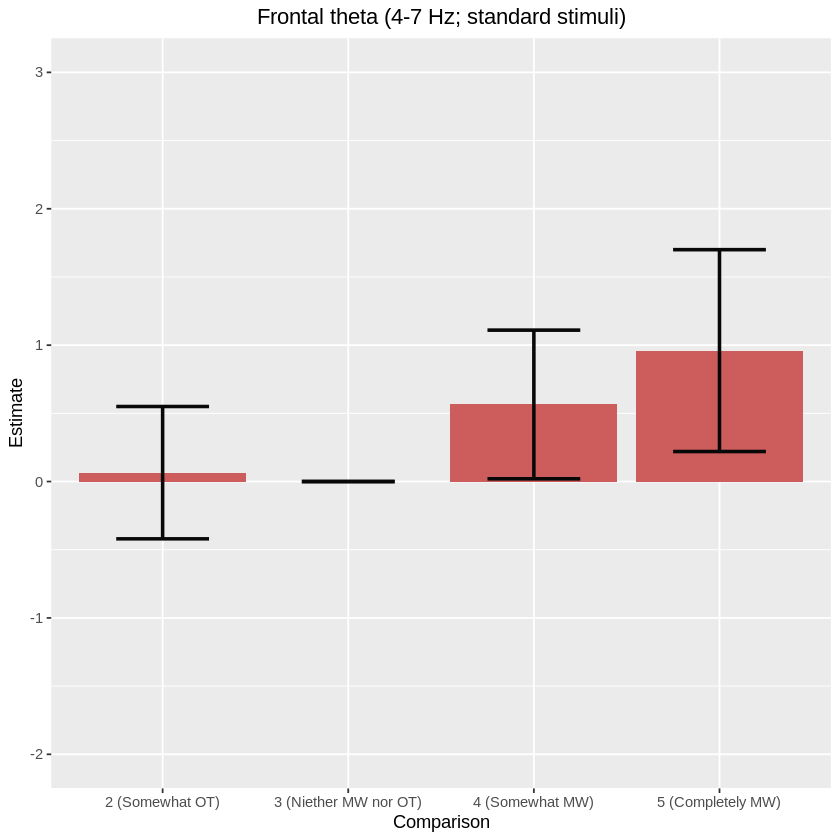

In [19]:
ggplot(posthocs, aes(x=Condition, y=Estimate)) + 
        geom_bar(position='dodge', stat='identity', fill='indianred' ) +
        geom_errorbar(aes(ymin = CIdown, ymax = CIup), 
                      size = 1, width = .5, 
                      position = position_dodge(width = .9), 
                      color = 'grey3') +
        ylim(-2,3) + 
        ggtitle("Frontal theta (4-7 Hz; standard stimuli)") +
        theme(plot.title = element_text(hjust=0.5)) +
        xlab("Comparison")

ggsave(filename='standard-theta.png', dpi=600)

# Compare MW1 oddball instead

In [20]:
# relevel data to focus on standard and MW1

dat[,'Condition'] <- relevel(dat[,'Condition'],'MW1')
dat[,'Stim'] <- relevel(dat[,'Stim'],'oddball')

cl <- makeCluster(num_cores)

m7r <- bam(PSD ~ Stim * Condition  
           + s(Subj, bs="re") 
           + s(Electrode_by_Subj, bs="re")  
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

stopCluster(cl)

In [21]:
mod = m7r

mod_summary = anova(mod)

mod_summary


Family: gaussian 
Link function: identity 

Formula:
PSD ~ Stim * Condition + s(Subj, bs = "re") + s(Electrode_by_Subj, 
    bs = "re") + s(Cond_by_Subj, bs = "re")

Parametric Terms:
               df     F  p-value
Stim            1 0.000 0.985919
Condition       4 4.794 0.000727
Stim:Condition  2 4.148 0.015805

Approximate significance of smooth terms:
                          edf   Ref.df       F  p-value
s(Subj)                0.9021   1.0000 75781.4   0.0014
s(Electrode_by_Subj) 224.7233 234.0000  1043.2  < 2e-16
s(Cond_by_Subj)      107.1359 168.0000   180.8 1.17e-14

In [22]:
summary(mod)


Family: gaussian 
Link function: identity 

Formula:
PSD ~ Stim * Condition + s(Subj, bs = "re") + s(Electrode_by_Subj, 
    bs = "re") + s(Cond_by_Subj, bs = "re")

Parametric coefficients:
                            Estimate Std. Error  t value Pr(>|t|)    
(Intercept)               -1.180e+02  3.924e-01 -300.617  < 2e-16 ***
Stimstandard               1.636e-03  9.268e-02    0.018   0.9859    
ConditionMW2               6.462e-02  1.955e-01    0.330   0.7410    
ConditionMW3               4.017e-01  2.366e-01    1.698   0.0896 .  
ConditionMW4               4.148e-01  2.471e-01    1.679   0.0932 .  
ConditionMW5               1.417e+00  3.402e-01    4.165 3.12e-05 ***
Stimstandard:ConditionMW2  0.000e+00  0.000e+00       NA       NA    
Stimstandard:ConditionMW3  0.000e+00  0.000e+00       NA       NA    
Stimstandard:ConditionMW4  1.528e-01  1.436e-01    1.064   0.2875    
Stimstandard:ConditionMW5 -4.542e-01  2.025e-01   -2.243   0.0249 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’

### Visualize these results

In [21]:
res <- t(summary(mod)$p.table[3,])
res <- as.data.frame(res)
res$Condition = paste("2 (Somewhat OT)")
posthocs <- res

res <- t(summary(mod)$p.table[4,])
res <- as.data.frame(res)
res$Condition = paste("3 (Niether MW nor OT)")
posthocs <- rbind(posthocs, res)

res <- t(summary(mod)$p.table[5,])
res <- as.data.frame(res)
res$Condition = paste("4 (Somewhat MW)")
posthocs <- rbind(posthocs, res)

res <- t(summary(mod)$p.table[6,])
res <- as.data.frame(res)
res$Condition = paste("5 (Completely MW)")
posthocs <- rbind(posthocs, res)

colnames(posthocs)[2] <- 'SE'
colnames(posthocs)[4] <- 'p (raw)'

# CIs
ncomp  <- dim(posthocs)[1] #-2 # The -2 is bc the age x polynomial contrasts are repeated for each group, but are teh same
thr <- adjust.se(alpha=0.05, df=1000, ncomp=ncomp)
posthocs$CIup <- round(posthocs$Estimate + thr * posthocs$SE, 2)
posthocs$CIdown <- round(posthocs$Estimate - thr * posthocs$SE, 2)

# Round for pretty table
posthocs[,'Estimate'] = round(posthocs[,'Estimate'],2)
posthocs[,'SE'] = round(posthocs[,'SE'],3)
posthocs[,'t value'] = round(posthocs[,'t value'],2)
posthocs[,'p (raw)'] = round(posthocs[,'p (raw)'],5)

# Reorder columns
posthocs = posthocs[,c('Condition', 'Estimate','SE','CIup','CIdown','t value','p (raw)')]


# Multiple comparison correction
posthocs$'p (Holm)'     <- round(p.adjust(posthocs$'p (raw)', method='holm', n <- ncomp), 4)

# write.csv(posthocs, file=paste(topdir, '/', expt, '_output/', 'stats ', CurTimeWin, 
#                                ' posthocs 4way BxGxVxR.csv' ,sep=''))

posthocs

Condition,Estimate,SE,CIup,CIdown,t value,p (raw),p (Holm)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2 (Somewhat OT),0.06,0.196,0.55,-0.42,0.33,0.74105,0.7410
3 (Niether MW nor OT),0.40,0.237,0.99,-0.19,1.70,0.08959,0.2688
4 (Somewhat MW),0.41,0.247,1.03,-0.20,1.68,0.09323,0.2688
5 (Completely MW),1.42,0.340,2.27,0.57,4.16,0.00003,0.0001


Saving 6.67 x 6.67 in image


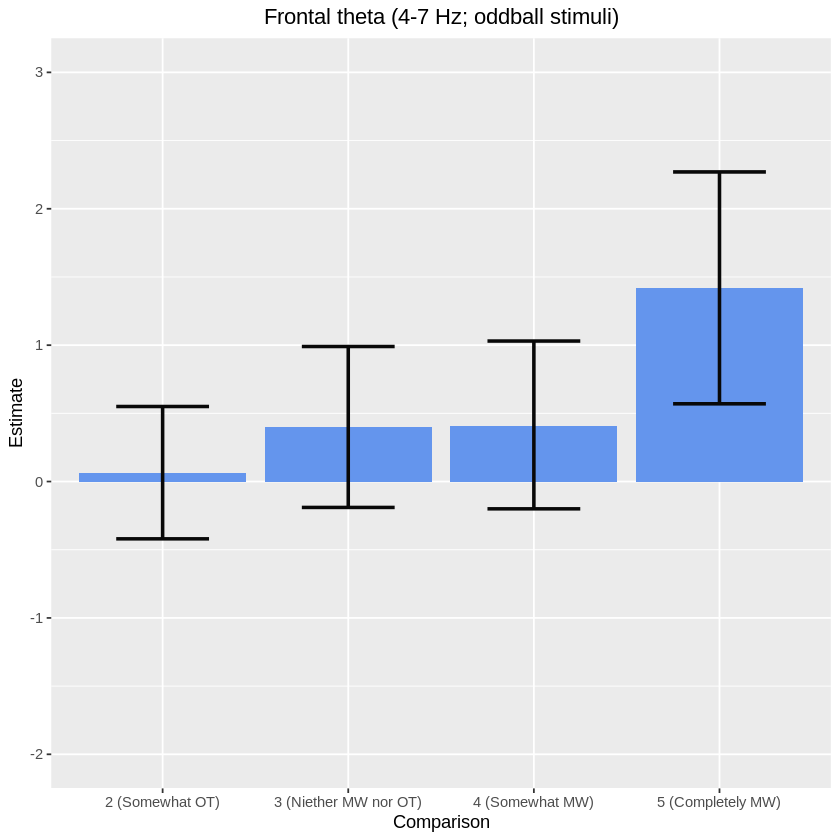

In [22]:
ggplot(posthocs, aes(x=Condition, y=Estimate)) + 
        geom_bar(position='dodge', stat='identity', fill='cornflowerblue' ) +
        geom_errorbar(aes(ymin = CIdown, ymax = CIup), 
                      size = 1, width = .5, 
                      position = position_dodge(width = .9), 
                      color = 'grey3') +
        ggtitle("Frontal theta (4-7 Hz; oddball stimuli)") +
        theme(plot.title = element_text(hjust=0.5)) +
        xlab("Comparison") + 
        ylim(-2,3)

ggsave(filename='oddball-theta.png', dpi=600)

## Compare standards and oddballs for each condition
This is in a loop to simplify the process.

In [26]:
# set up initial posthoc

dat <- subset(bdat, Region == 'frontal') #change this as needed

dat[,'Condition'] <- relevel(dat[,'Condition'],'MW1')
dat[,'Stim'] <- relevel(dat[,'Stim'],'standard')

cl <- makeCluster(num_cores)

m8r <- bam(PSD ~ Stim * Condition  
           + s(Subj, bs="re") 
           + s(Electrode_by_Subj, bs="re")  
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

stopCluster(cl)

mod = m8r

res <- t(summary(mod)$p.table[2,])
res <- as.data.frame(res)
res$Condition = paste("1 (Completely OT)")
posthocs <- res

# include the subsequent levels, looping through
mw_levels <- c('MW2','MW3','MW4','MW5')
axis_labels <- c('2 (Somewhat OT)', '3 (Neither MW nor OT)', '4 (Somewhat MW)', '5 (Completely MW)')

for(i in 1:4){
    dat[,'Condition'] <- relevel(dat[,'Condition'],mw_levels[i])
    dat[,'Stim'] <- relevel(dat[,'Stim'],'standard')

    cl <- makeCluster(num_cores)

    m8r <- bam(PSD ~ Stim * Condition  
               + s(Subj, bs="re") 
               + s(Electrode_by_Subj, bs="re")  
               + s(Cond_by_Subj, bs="re"),
              data = dat, 
              samfrac=0.1, cluster=cl, gc.level=2)

    stopCluster(cl)

    mod = m8r

    res <- t(summary(mod)$p.table[2,])
    res <- as.data.frame(res)
    res$Condition = paste(axis_labels[i])
    posthocs <- rbind(posthocs, res)
}

In [31]:
## Clean up posthocs

colnames(posthocs)[2] <- 'SE'
colnames(posthocs)[4] <- 'p (raw)'

# CIs
ncomp  <- dim(posthocs)[1] #-2 # The -2 is bc the age x polynomial contrasts are repeated for each group, but are teh same
thr <- adjust.se(alpha=0.05, df=1000, ncomp=ncomp)
posthocs$CIup <- round(posthocs$Estimate + thr * posthocs$SE, 2)
posthocs$CIdown <- round(posthocs$Estimate - thr * posthocs$SE, 2)

# Round for pretty table
posthocs[,'Estimate'] = round(posthocs[,'Estimate'],2)
posthocs[,'SE'] = round(posthocs[,'SE'],3)
posthocs[,'t value'] = round(posthocs[,'t value'],2)
posthocs[,'p (raw)'] = round(posthocs[,'p (raw)'],5)

# Reorder columns
posthocs = posthocs[,c('Condition', 'Estimate','SE','CIup','CIdown','t value','p (raw)')]


# Multiple comparison correction
posthocs$'p (Holm)'     <- round(p.adjust(posthocs$'p (raw)', method='holm', n <- ncomp), 4)

# write.csv(posthocs, file=paste(topdir, '/', expt, '_output/', 'stats ', CurTimeWin, 
#                                ' posthocs 4way BxGxVxR.csv' ,sep=''))

posthocs

Condition,Estimate,SE,CIup,CIdown,t value,p (raw),p (Holm)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1 (Completely OT),0.00,0.093,0.24,-0.24,-0.02,0.98592,0.9859
2 (Somewhat OT),-0.15,0.110,0.13,-0.44,-1.41,0.15938,0.6375
3 (Neither MW nor OT),-0.15,0.110,0.13,-0.44,-1.41,0.15938,0.6375
4 (Somewhat MW),-0.15,0.110,0.13,-0.44,-1.41,0.15938,0.6375
5 (Completely MW),0.45,0.180,0.92,-0.01,2.51,0.01195,0.0598


Saving 6.67 x 6.67 in image


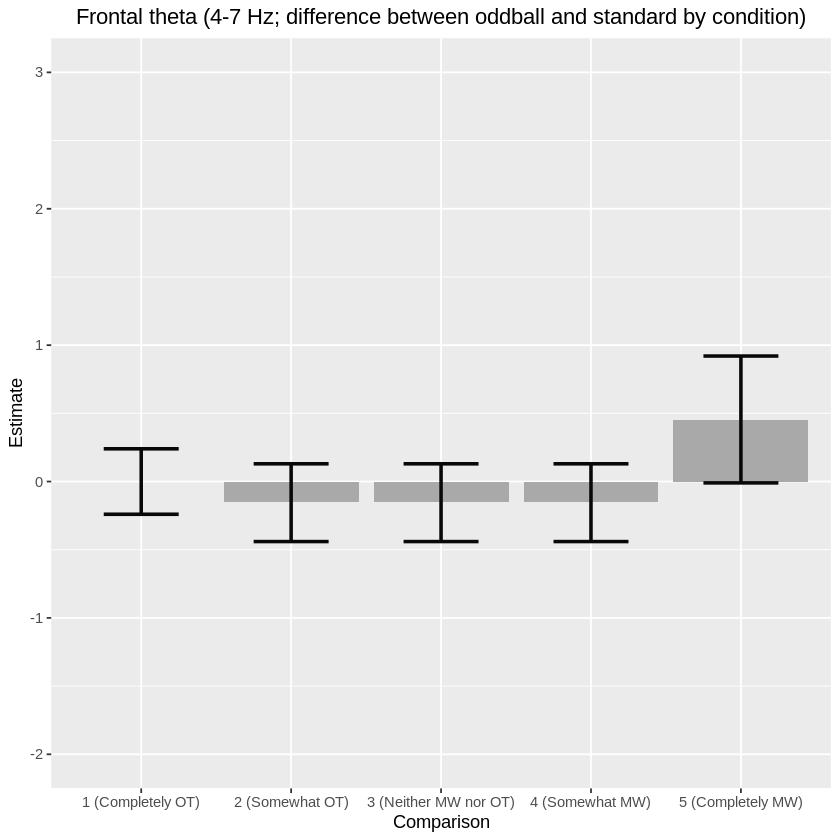

In [32]:
ggplot(posthocs, aes(x=Condition, y=Estimate)) + 
        geom_bar(position='dodge', stat='identity', fill='darkgray' ) +
        geom_errorbar(aes(ymin = CIdown, ymax = CIup), 
                      size = 1, width = .5, 
                      position = position_dodge(width = .9), 
                      color = 'grey3') +
        ggtitle("Frontal theta (4-7 Hz; difference between oddball and standard by condition)") +
        theme(plot.title = element_text(hjust=0.5)) +
        xlab("Comparison") + 
        ylim(-2,3)

ggsave(filename='oddball-difference-theta.png', dpi=600)